In [3]:
import numpy as np
from random_mdp import MDPEnv, MDPEnvDiscreteRew, MDPEnvBernoulliRew
from agent import QlearningAgent
from greedy_policy import EpsilonGreedyPolicy, TableBasedPolicy, MixedPolicy
from utils import get_data, collect_exp, train_predictor, train_behaviour_policy, compute_weight, compute_weights_gradient, train_weight_function
from networks import MLP, WeightsMLP
from dynamics_model import DynamicsModel, DiscreteRewardDynamicsModel
import torch
from collections import defaultdict
import pickle
import random
from weights import WeightsEstimator
from conformal_set import ConformalSet
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
set_seed(1)

REWARD_TYPE = "bernoulli"
GRADIENT_BASED = True
EPSILON = 0.3
QUANTILE = 0.1
LR = 1e-4
MOMENTUM = 0.9
EPOCHS = 100
NUM_ACTIONS = 5                                                                     # MDP action space size
NUM_STATES = 10                                                                     # MDP states space size
NUM_REWARDS = 10                                                                    # MDP reward space size (for discrete MDP)
DISCOUNT_FACTOR = 0.99                                                              # behaviour agent discount factor
ALPHA = 0.6                                                                         # behaviour agent alpha
NUM_STEPS = 10000                                                                   # behaviour agent learning steps
N_TRAJECTORIES = 20000                                                              # number of trajectories collected as dataset
HORIZON = 30                                                                        # trajectory horizon

P = np.random.dirichlet(np.ones(NUM_STATES), size=(NUM_STATES, NUM_ACTIONS))        # MDP transition probability functions

if REWARD_TYPE == "bernoulli":
    R = np.random.rand(NUM_STATES, NUM_ACTIONS)                                     # MDP reward function Bernoulli
    env = MDPEnvBernoulliRew(NUM_STATES, NUM_ACTIONS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "discrete_multiple":                                 
    R = np.random.dirichlet(np.ones(NUM_REWARDS), size=(NUM_STATES, NUM_ACTIONS))   # MDP reward function multiple discrete r values
    env = MDPEnvDiscreteRew(NUM_STATES, NUM_ACTIONS, NUM_REWARDS, P, R)
    model = DiscreteRewardDynamicsModel(NUM_STATES, NUM_ACTIONS, NUM_REWARDS)
elif REWARD_TYPE == "continuous":
    # TODO: implement continuous rewards model, the "true" MDP we already have
    R = np.random.rand(NUM_STATES, NUM_ACTIONS, NUM_STATES)
    env = MDPEnv(NUM_STATES, NUM_ACTIONS, P, R)

pi_star_probs = np.random.dirichlet(np.ones(NUM_ACTIONS), size=(NUM_STATES))
pi_star_pre = TableBasedPolicy(pi_star_probs)


#Train behaviour policy using Q-learning
agent = QlearningAgent(env.ns, NUM_ACTIONS, DISCOUNT_FACTOR, ALPHA)

q_table = train_behaviour_policy(env, agent, NUM_STEPS)
behaviour_policy = EpsilonGreedyPolicy(q_table, EPSILON, NUM_ACTIONS)

#Collect experience data using behaviour policy and train model
#TODO: improve storage system
model, dataset = get_data(env, N_TRAJECTORIES, behaviour_policy, model, REWARD_TYPE, HORIZON)

#Split dataset into training (90%) and calibration data (10%)
calibration_trajectories = N_TRAJECTORIES // 10
data_tr = dataset[:N_TRAJECTORIES - calibration_trajectories]
data_cal = dataset[N_TRAJECTORIES - calibration_trajectories:N_TRAJECTORIES]
test_state = np.random.randint(NUM_STATES)

#Train quantile predictors using training dataset
print('> Training/loading quantile networks')
upper_quantile_net = MLP(1, 32, 1, False)
lower_quantile_net = MLP(1, 32, 1, False)

if not lower_quantile_net.load('./data/networks/lower_quantile_net.pth'):
    y_avg, y_std = train_predictor(lower_quantile_net, data_tr, epochs=EPOCHS, quantile=QUANTILE/2, lr=LR, momentum=MOMENTUM)
    lower_quantile_net.set_normalization(y_avg, y_std)
    lower_quantile_net.save('./data/networks/lower_quantile_net.pth')

if not upper_quantile_net.load('./data/networks/upper_quantile_net.pth'):
    y_avg, y_std = train_predictor(upper_quantile_net, data_tr, epochs=EPOCHS, quantile=1-(QUANTILE/2), lr=LR, momentum=MOMENTUM)
    upper_quantile_net.set_normalization(y_avg, y_std)
    upper_quantile_net.save('./data/networks/upper_quantile_net.pth')

> Loading/collecting data
> Training/loading quantile networks


In [4]:
from tqdm.notebook import tqdm

epsilons = np.linspace(0.05, 0.9, 10)
N_SIMS = 10

epsilon_avg_lengths = np.zeros((N_SIMS, len(epsilons)))
epsilon_std_lengths = np.zeros((N_SIMS, len(epsilons)))
coverages = np.zeros((N_SIMS, len(epsilons)))

for n in range(N_SIMS):
    print(f'Sim: {n}')
    for id_epsilon, epsilon_value in enumerate(epsilons):
        print(f'Epsilon = {epsilon_value}')
        pi_star = MixedPolicy(pi_star_pre, behaviour_policy, epsilon_value)
        test_points = collect_exp(env, 100, HORIZON, pi_star, None, test_state)

        print(f'> Estimate weights for calibration data')
        weights_estimator = WeightsEstimator(behaviour_policy, pi_star, lower_quantile_net, upper_quantile_net)
        if GRADIENT_BASED:
            scores, weights, weight_network = weights_estimator.gradient_method(data_tr, data_cal, LR, EPOCHS, lambda:WeightsMLP(2, 32, 1, upper_quantile_net.mean, upper_quantile_net.std))
        else:
            scores, weight = weights_estimator.model_based(data_tr, data_cal, HORIZON, model)

        # Generate y values for test point
        print(f'> Computing conformal set')
        conformal_set = ConformalSet(lower_quantile_net, upper_quantile_net, behaviour_policy, pi_star, model, HORIZON)
        y_set, intervals = conformal_set.build_set(test_points, weights, scores, weight_network, GRADIENT_BASED)

        included = 0
        lengths = []
        for interval in intervals:
            if interval[-1] >= interval[2] and interval[-1] <= interval[3]:
                included += 1
            lengths.append(interval[3]-interval[2])

        included = included/len(intervals)
        mean_length = np.mean(lengths)
        epsilon_avg_lengths[n, id_epsilon] = mean_length
        epsilon_std_lengths[n, id_epsilon] = np.std(lengths)
        coverages[n, id_epsilon] = included * 100
        print("Coverage: {:.2f}% | Average interval length: {}".format(included*100, mean_length))

Sim: 0
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.671833491760481e-07 - Loss val: 1.477447540310095e-06: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s] 


> Computing conformal set


/home/alessio/Conformal_OPE_MDP/conformal_set.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = torch.tensor(scores)


Coverage: 63.00% | Average interval length: 9.002727508544922
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 9.731660247780383e-05 - Loss val: 0.0008334917947649956: 100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


> Computing conformal set
Coverage: 68.00% | Average interval length: 9.002727508544922
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0023407258559018373 - Loss val: 0.07097946852445602: 100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


> Computing conformal set
Coverage: 84.00% | Average interval length: 9.005807876586914
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.1977231204509735 - Loss val: 1.2978514432907104: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


> Computing conformal set
Coverage: 79.00% | Average interval length: 9.002307891845703
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.49777907133102417 - Loss val: 8.024909973144531: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


> Computing conformal set
Coverage: 83.00% | Average interval length: 9.005807876586914
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7860119342803955 - Loss val: 21.86028289794922: 100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.007566452026367
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.687177658081055 - Loss val: 29.09585952758789: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 9.007566452026367
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.8111956119537354 - Loss val: 19.699405670166016: 100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.009986877441406
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 15.380297660827637 - Loss val: 7.02312707901001: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s] 


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.007566452026367
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.3280264139175415 - Loss val: 1.219178318977356: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.005807876586914
Sim: 1
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.165730155771598e-06 - Loss val: 5.485751444211928e-07: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


> Computing conformal set
Coverage: 53.00% | Average interval length: 8.994426727294922
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.805399607401341e-05 - Loss val: 0.0007916772156022489: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


> Computing conformal set
Coverage: 66.00% | Average interval length: 9.005807876586914
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0036844678688794374 - Loss val: 0.07191228121519089: 100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


> Computing conformal set
Coverage: 67.00% | Average interval length: 8.994426727294922
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.018786191940307617 - Loss val: 1.2861859798431396: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


> Computing conformal set
Coverage: 73.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 12.540160179138184 - Loss val: 8.055072784423828: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 9.007566452026367
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.632327079772949 - Loss val: 21.898242950439453: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005807876586914
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 15.254075050354004 - Loss val: 28.95272445678711: 100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


> Computing conformal set
Coverage: 90.00% | Average interval length: 9.007566452026367
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 72.12720489501953 - Loss val: 19.6793155670166: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s] 


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.009986877441406
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.8529318571090698 - Loss val: 6.958771228790283: 100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.007566452026367
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.853757381439209 - Loss val: 1.1912200450897217: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 9.007566452026367
Sim: 2
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.137631784331461e-06 - Loss val: 1.5474593055841979e-06: 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


> Computing conformal set
Coverage: 75.00% | Average interval length: 9.002307891845703
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.7762805479578674e-05 - Loss val: 0.000731924781575799: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


> Computing conformal set
Coverage: 71.00% | Average interval length: 9.009180068969727
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0021393154747784138 - Loss val: 0.07096400111913681: 100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


> Computing conformal set
Coverage: 79.00% | Average interval length: 9.002405378553602
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.05499083176255226 - Loss val: 1.2933332920074463: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.3409447968006134 - Loss val: 8.049492835998535: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


> Computing conformal set
Coverage: 81.00% | Average interval length: 9.005807876586914
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 7.894937515258789 - Loss val: 21.901811599731445: 100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.007566452026367
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.391350030899048 - Loss val: 28.924806594848633: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 9.005147933959961
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 21.285972595214844 - Loss val: 19.768281936645508: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.007566452026367
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.9682673215866089 - Loss val: 6.967382907867432: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 9.007566452026367
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.7488795518875122 - Loss val: 1.2100183963775635: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 9.005807876586914
Sim: 3
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.854168077552458e-06 - Loss val: 7.998084583960008e-06: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s] 


> Computing conformal set
Coverage: 64.00% | Average interval length: 9.002307891845703
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0012240250362083316 - Loss val: 0.0008768577827140689: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


> Computing conformal set
Coverage: 74.00% | Average interval length: 9.002483367919922
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.2698354721069336 - Loss val: 0.07128256559371948: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


> Computing conformal set
Coverage: 68.00% | Average interval length: 9.007566452026367
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.02623235434293747 - Loss val: 1.2984001636505127: 100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


> Computing conformal set
Coverage: 73.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 164.62588500976562 - Loss val: 8.039499282836914: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 9.005807876586914
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 12.067516326904297 - Loss val: 21.86684226989746: 100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.007566452026367
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 13.571799278259277 - Loss val: 29.020774841308594: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.007371054755318
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.034057140350342 - Loss val: 19.714021682739258: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 9.005807876586914
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.3344035148620605 - Loss val: 7.023975372314453: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.005807876586914
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.8651896715164185 - Loss val: 1.2100611925125122: 100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 9.005807876586914
Sim: 4
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.8998001394265884e-08 - Loss val: 6.386469522112748e-07: 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


> Computing conformal set
Coverage: 68.00% | Average interval length: 9.005147933959961
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00015587688540108502 - Loss val: 0.0007540699443779886: 100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


> Computing conformal set
Coverage: 69.00% | Average interval length: 9.002483367919922
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0027037744875997305 - Loss val: 0.07136011123657227: 100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


> Computing conformal set
Coverage: 78.00% | Average interval length: 9.002483367919922
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.601125478744507 - Loss val: 1.3007864952087402: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


> Computing conformal set
Coverage: 82.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 35.03571701049805 - Loss val: 8.021790504455566: 100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 9.002483367919922
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 3.6646883487701416 - Loss val: 21.821002960205078: 100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005147933959961
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 46.993831634521484 - Loss val: 29.004549026489258: 100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 9.005807876586914
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 23.04989242553711 - Loss val: 19.683290481567383: 100%|██████████| 100/100 [00:10<00:00,  9.28it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.530387878417969
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.396369218826294 - Loss val: 7.027988910675049: 100%|██████████| 100/100 [00:10<00:00,  9.43it/s] 


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.005147933959961
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7367709875106812 - Loss val: 1.2080411911010742: 100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


> Computing conformal set
Coverage: 97.00% | Average interval length: 9.005807876586914
Sim: 5
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00040657827048562467 - Loss val: 0.0002129916538251564: 100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


> Computing conformal set
Coverage: 63.00% | Average interval length: 9.002483367919922
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00013133023458067328 - Loss val: 0.000787744764238596: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


> Computing conformal set
Coverage: 80.00% | Average interval length: 9.002307891845703
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.003734826808795333 - Loss val: 0.0713772401213646: 100%|██████████| 100/100 [00:10<00:00,  9.50it/s] 


> Computing conformal set
Coverage: 78.00% | Average interval length: 9.005807876586914
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.048294954001903534 - Loss val: 1.3036776781082153: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


> Computing conformal set
Coverage: 85.00% | Average interval length: 9.005147933959961
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.19406448304653168 - Loss val: 8.044011116027832: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 9.002483367919922
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 58.58684158325195 - Loss val: 21.824159622192383: 100%|██████████| 100/100 [00:10<00:00,  9.38it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.007566452026367
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.1254773139953613 - Loss val: 28.999120712280273: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005807876586914
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.663882255554199 - Loss val: 19.703927993774414: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.002483367919922
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 16.55221939086914 - Loss val: 7.083530902862549: 100%|██████████| 100/100 [00:09<00:00, 10.04it/s] 


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.005807876586914
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7472347021102905 - Loss val: 1.209901213645935: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.009986877441406
Sim: 6
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.74118791721412e-06 - Loss val: 1.2564635653689038e-05: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s] 


> Computing conformal set
Coverage: 69.00% | Average interval length: 9.005807876586914
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.613108103512786e-05 - Loss val: 0.0007505227695219219: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


> Computing conformal set
Coverage: 71.00% | Average interval length: 9.00030517578125
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0026491787284612656 - Loss val: 0.07155726104974747: 100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


> Computing conformal set
Coverage: 56.00% | Average interval length: 8.994426727294922
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 36.96613693237305 - Loss val: 1.293673038482666: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s] 


> Computing conformal set
Coverage: 83.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.1515607237815857 - Loss val: 8.05772590637207: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s] 


> Computing conformal set
Coverage: 88.00% | Average interval length: 9.005294587877062
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.5753350257873535 - Loss val: 21.857664108276367: 100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.007566452026367
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.7204461097717285 - Loss val: 29.021352767944336: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.005807876586914
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.2365593910217285 - Loss val: 19.790721893310547: 100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.005807876586914
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 6.121891021728516 - Loss val: 7.110429763793945: 100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.005807876586914
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7640209197998047 - Loss val: 1.2213926315307617: 100%|██████████| 100/100 [00:09<00:00, 10.00it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.002483367919922
Sim: 7
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.307396466174396e-06 - Loss val: 3.855929207929876e-06: 100%|██████████| 100/100 [00:10<00:00,  9.86it/s] 


> Computing conformal set
Coverage: 61.00% | Average interval length: 9.002483367919922
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.052240367978811264 - Loss val: 0.0007962984964251518: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


> Computing conformal set
Coverage: 79.00% | Average interval length: 9.005807876586914
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0033279256895184517 - Loss val: 0.07112403959035873: 100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


> Computing conformal set
Coverage: 73.00% | Average interval length: 9.002483367919922
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.17560452222824097 - Loss val: 1.3000059127807617: 100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


> Computing conformal set
Coverage: 76.00% | Average interval length: 9.005147933959961
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 34.39693069458008 - Loss val: 8.033891677856445: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


> Computing conformal set
Coverage: 83.00% | Average interval length: 9.002727508544922
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 10.936545372009277 - Loss val: 21.89129638671875: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


> Computing conformal set
Coverage: 89.00% | Average interval length: 9.005807876586914
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 10.040199279785156 - Loss val: 28.963886260986328: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.002483367919922
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 4.628414630889893 - Loss val: 19.815420150756836: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.005807876586914
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.562873363494873 - Loss val: 7.020256519317627: 100%|██████████| 100/100 [00:10<00:00,  9.91it/s] 


> Computing conformal set
Coverage: 96.00% | Average interval length: 9.007566452026367
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.0181699991226196 - Loss val: 1.1976767778396606: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.012405395507812
Sim: 8
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.3358500837057363e-05 - Loss val: 1.5059341649248381e-06: 100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


> Computing conformal set
Coverage: 70.00% | Average interval length: 9.139881134033203
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.5915239499881864e-05 - Loss val: 0.0007842144696041942: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


> Computing conformal set
Coverage: 73.00% | Average interval length: 9.002307891845703
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.4917111098766327 - Loss val: 0.07079833745956421: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


> Computing conformal set
Coverage: 81.00% | Average interval length: 9.005147933959961
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.03522936627268791 - Loss val: 1.2967408895492554: 100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


> Computing conformal set
Coverage: 87.00% | Average interval length: 9.005807876586914
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.3999163508415222 - Loss val: 8.049428939819336: 100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


> Computing conformal set
Coverage: 80.00% | Average interval length: 9.005807876586914
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 93.05750274658203 - Loss val: 21.774293899536133: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


> Computing conformal set
Coverage: 88.00% | Average interval length: 9.005147933959961
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.1604417562484741 - Loss val: 28.966691970825195: 100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.002483367919922
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.795544385910034 - Loss val: 19.74872398376465: 100%|██████████| 100/100 [00:10<00:00,  9.41it/s] 


> Computing conformal set
Coverage: 95.00% | Average interval length: 9.005807876586914
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 2.28737211227417 - Loss val: 6.996293544769287: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]  


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005807876586914
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.7820820808410645 - Loss val: 1.1998199224472046: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005807876586914
Sim: 9
Epsilon = 0.05
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.0001347343495581299 - Loss val: 0.0001590772153576836: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s] 


> Computing conformal set
Coverage: 73.00% | Average interval length: 9.005807876586914
Epsilon = 0.14444444444444443
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 7.45798388379626e-05 - Loss val: 0.0007659488474018872: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s] 


> Computing conformal set
Coverage: 74.00% | Average interval length: 9.005147933959961
Epsilon = 0.23888888888888887
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.00448258314281702 - Loss val: 0.07219373434782028: 100%|██████████| 100/100 [00:09<00:00, 10.20it/s] 


> Computing conformal set
Coverage: 74.00% | Average interval length: 9.005807876586914
Epsilon = 0.3333333333333333
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 135.73321533203125 - Loss val: 1.3048664331436157: 100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 9.002483367919922
Epsilon = 0.42777777777777776
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 0.16367748379707336 - Loss val: 8.046588897705078: 100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


> Computing conformal set
Coverage: 86.00% | Average interval length: 9.005807876586914
Epsilon = 0.5222222222222223
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 14.95315933227539 - Loss val: 21.837947845458984: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


> Computing conformal set
Coverage: 83.00% | Average interval length: 9.005807876586914
Epsilon = 0.6166666666666667
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 5.2908525466918945 - Loss val: 29.019411087036133: 100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


> Computing conformal set
Coverage: 94.00% | Average interval length: 9.005147933959961
Epsilon = 0.7111111111111111
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 30.439603805541992 - Loss val: 19.778335571289062: 100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


> Computing conformal set
Coverage: 92.00% | Average interval length: 9.005807876586914
Epsilon = 0.8055555555555556
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 7.346947193145752 - Loss val: 7.003200531005859: 100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


> Computing conformal set
Coverage: 93.00% | Average interval length: 9.009986877441406
Epsilon = 0.9
> Estimate weights for calibration data
> Computing weight of trajectories


Epoch 99 - Training weights network - Loss: 1.8734740018844604 - Loss val: 1.226459264755249: 100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


> Computing conformal set
Coverage: 91.00% | Average interval length: 9.005147933959961


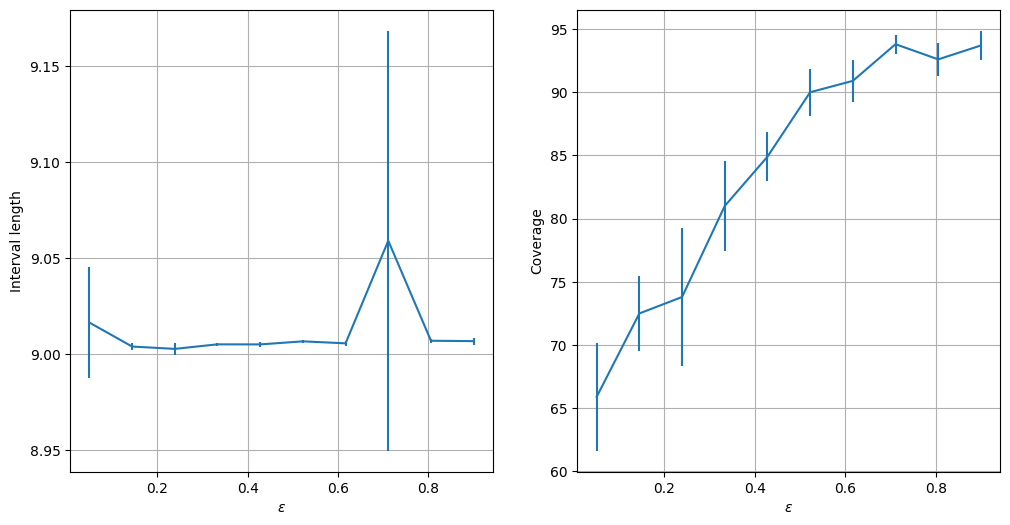

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].errorbar(epsilons, epsilon_avg_lengths.mean(0), 2.2*epsilon_avg_lengths.std(0) / np.sqrt(epsilon_avg_lengths.shape[0]))
ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Interval length')
ax[0].grid()


ax[1].errorbar(epsilons, coverages.mean(0), 2.2*coverages.std(0) / np.sqrt(coverages.shape[0]))
ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Coverage')
ax[1].grid()
plt.savefig('results.pdf')